# Deep Learning assignment #1

### Learning mirror symmetries in 6-digits numbers

Let us reproduce the experiment reported in the figure below

In [22]:
import numpy as np
import torch as th
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import Tensor
from matplotlib import pyplot as plt
from icecream import ic
import random
import itertools
from tqdm.auto import trange
from ebtorch.nn.utils import eval_model_on_test

from typing import List

In [23]:
INPUT_SIZE = 6
OUTPUT_SIZE = 1
DATASET_SIZE = 1000
TRAIN_BATCH_SIZE = 1
SYMMETRY_PERC = 50
DEVICE_AUTODETECT: bool = True
CRITERION = th.nn.MSELoss()
NUM_ACCUMULATION_STEPS = 64

In [24]:
# Let's detect and select the most appropriate device
device: th.device = th.device(
    "cuda" if th.cuda.is_available() and DEVICE_AUTODETECT else "cpu"
)

## Creating dataset

According to the paper, the model is trained on 1425 sweeps through the **set of 64 possible input vectors**. Therefore, a first implementation was based on the generation and training over this set. The vectors contain either 0s or 1s, but the dataset dtype is `th.float32` for compatibility with `Pytorch`'s utils.

The problem with this approach, however, is that there are only 8 symmetric combinations in the training dataset, i.e. only 12.5% of the vectors represent the symmetric class. This is a typical *data imbalance* problem, which was solved by creating a custom dataset of vectors containing a **given percentage of symmetric vectors**. In particular, the `SYMMETRY_PERC` constant is needed to specify this percentage. If this is not done, the model doesn't learn how to deal with the least represented class but the accuracy will remain high. In fact, if we denote by $p$ the number of data points of the most frequent class and by $n$ the lenght of the dataset, the accuracy will be equal to $\frac{p}{n}$ if the model always predicts the frequent class. In this specific case $\frac{p}{n} = 0.875$

In [43]:
# Generating sets of symmetric and not symmetric vectors
vectors = list(itertools.product([0, 1], repeat=6))
symmetric_vectors = [vector for vector in vectors if vector[:3] == vector[3:][::-1]]
not_symmetric_vectors = [vector for vector in vectors if vector not in symmetric_vectors]

In [26]:
np.random.seed(42) # For reproducibility

class SymDetDataset(Dataset):
    """Symmetry Detector Dataset: generates random vectors and labels them as symmetric or not
    
    Args:
        tot_size (int): total number of samples to generate
        sym_percentage (int): percentage of symmetric vectors to generate
    """

    def __init__(self, tot_size = 100, sym_percentage: th.int =50):
        data = [], labels = []

        if sym_percentage <0 or sym_percentage > 100:
            print("Error: invalid 'sym_percentage' parameter value. Should be number between 0 and 100.")   # Just a little debug print

        for _ in range(tot_size):
            n = np.random.rand(1)*100
            if n <= sym_percentage:
                vector = random.choice(symmetric_vectors)
            else:
                vector = random.choice(not_symmetric_vectors)

            data.append(vector)
            labels.append(int(np.array_equal(vector[:3], vector[3:][::-1])))

        data = np.array(data)
        self.data = th.tensor(data).to(th.float32)      # Conversion for PyTorch compatibility
        self.labels = th.tensor(labels).to(th.float32)

    def __len__(self):      # Required methods for PyTorch Dataset
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        label = self.labels[index]
        return sample, label

In [27]:
# Dataset which contains all possible combinations of 6 binary digits
class AllPossibleVectorsDataset(Dataset):
    """AllPossibleVectorsDataset: generates all possible combinations of 6 binary digits and labels them as symmetric or not."""

    def __init__(self):
        data = []
        labels = []

        # Generate all possible combinations of 6 binary digits
        for vector in itertools.product([0, 1], repeat=6):
            data.append(vector)
            labels.append(int(np.array_equal(vector[:3], vector[3:][::-1])))

        data = np.array(data)
        self.data = th.tensor(data).to(th.float32)      # Conversion for PyTorch compatibility
        self.labels = th.tensor(labels).to(th.float32)

    def __len__(self):  # Required methods for PyTorch Dataset
        return len(self.data)
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        label = self.labels[index]
        return sample, label

The following cell is to use the SymDetDataset datasest generator

In [28]:
train_dataset = SymDetDataset(tot_size=DATASET_SIZE, sym_percentage=SYMMETRY_PERC)
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

test_dataset = SymDetDataset(tot_size=int(DATASET_SIZE * 0.2), sym_percentage=50)
test_loader = DataLoader(test_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

The following cell is to use the AllPossibleVectorsDataset dataset generator

In [29]:
# train_dataset = AllPossibleVectorsDataset()
# train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=False)

# test_dataset = AllPossibleVectorsDataset()
# test_loader = DataLoader(test_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=False)

## Model definition

<div>
<img src="./images/fig1.png" width="500"/>
</div>

The model in the figure above contains 2 hidden units

In [31]:
class SymmetryDetector(th.nn.Module):
    def __init__(self, final_threshold: float = 0.5):
        super().__init__()
        self.final_threshold = final_threshold

        self.h1: th.nn.Module = th.nn.Linear(
            in_features=INPUT_SIZE, out_features=OUTPUT_SIZE, bias=True)
        self.h2: th.nn.Module = th.nn.Linear(
            in_features=INPUT_SIZE, out_features=OUTPUT_SIZE, bias=True)
        self.h3: th.nn.Module = th.nn.Linear(
            in_features=2*OUTPUT_SIZE, out_features=OUTPUT_SIZE, bias=True)

    def forward(self, x_: th.Tensor) -> th.float:
        x1 = self.h1(x_)
        y1 = th.nn.functional.sigmoid(x1)
        x2 = self.h2(x_)
        y2 = th.nn.functional.sigmoid(x2)

        y = self.h3(th.cat((y1, y2), dim=1))
        y = th.nn.functional.sigmoid(y) # Final sigmoid to get the output in [0,1]

        return y

In [32]:
model = SymmetryDetector().to(device)

## Weights initialization

In [33]:
# Define the custom weight initialization function
def init_weights_uniform_custom_range(m):
    if isinstance(m, th.nn.Linear):
        # Define the custom range for the uniform distribution
        custom_range_min = -0.3
        custom_range_max = 0.3
        # Apply uniform initialization to the weights of the linear layer
        th.nn.init.uniform_(m.weight, a=custom_range_min, b=custom_range_max)
        # Initialize biases, if present
        if m.bias is not None:
            th.nn.init.constant_(m.bias, 0.0)


model.apply(init_weights_uniform_custom_range)

SymmetryDetector(
  (h1): Linear(in_features=6, out_features=1, bias=True)
  (h2): Linear(in_features=6, out_features=1, bias=True)
  (h3): Linear(in_features=2, out_features=1, bias=True)
)

In [34]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Dtype: {param.dtype}  | {param.data}")

Layer: h1.weight | Dtype: torch.float32  | tensor([[-0.1635, -0.1920, -0.0583, -0.1381,  0.2884,  0.2221]])
Layer: h1.bias | Dtype: torch.float32  | tensor([0.])
Layer: h2.weight | Dtype: torch.float32  | tensor([[-0.1140,  0.2253, -0.2803,  0.0801,  0.2731,  0.2408]])
Layer: h2.bias | Dtype: torch.float32  | tensor([0.])
Layer: h3.weight | Dtype: torch.float32  | tensor([[0.1110, 0.2634]])
Layer: h3.bias | Dtype: torch.float32  | tensor([0.])


## Loss function

In [35]:
loss: th.nn.Module = th.nn.MSELoss()

In [36]:
eps = 0.1
alpha = 0.9
n_sweeps = 1425

## Optimizer

### No momentum

In [37]:
optimizer: th.optim.Optimizer = th.optim.SGD(params=model.parameters(), momentum=0, lr=alpha)

![image](./images/parameters.png) 

### The (actual) training loop
In our case the model is trained on **the set of 64 possible input vectors**. Therefore, there each batch contains one of the 64 elements (in order) and the gradient is accumulated when this *sweep* is finished, i.e. when all 64 batches (and input vectors) are seen by the model.

```
Loop over epochs:
    Loop over possible vectors:
        Perform a forward pass
        Compute the loss on current point
        Accumulate gradient calculated on current point
    Update model parameters based on accumulated gradient
```

Using the same data as the experiment in the paper:
- 1425 sweeps throught the set of 64 possible input vectors
- accumulate gradient using $\Delta w(t) = -\epsilon \frac{\delta E}{\delta w(t)} + \alpha \Delta w (t-1)$
  - where $t$ is incremented by 1 at each sweep
  - $\alpha = 0.9$
  - $\epsilon = 0.1$

## Training

In [38]:
eval_losses: List[float] = []
eval_acc: List[float] = []
test_acc: List[float] = []


for epoch in trange(n_sweeps, desc="Training epoch"):
    total_loss = 0.0
    model.train()

    optimizer.zero_grad() # Reset the gradients for next accumulation
    for batch_idx, batch in enumerate(train_loader):
        x, y = batch
        x, y = x.to(device), y.to(device)
        yhat = model(x)
        # prediction = (yhat >= model.final_threshold).float()
        # loss = CRITERION(prediction, y)
        loss = CRITERION(yhat, y)
        loss = loss / NUM_ACCUMULATION_STEPS
        loss.backward()
        
        if (batch_idx + 1) % NUM_ACCUMULATION_STEPS == 0:
            optimizer.step()
            optimizer.zero_grad() # Reset the gradients for next accumulation
    
    # Log the loss and accuracy on the training set...
    num_elem: int = 0
    trackingmetric: float = 0
    trackingcorrect: int = 0

    model.eval()  # Remember to set the model in evaluation mode before evaluating it

    # Since we are just evaluating the model, we don't need to compute gradients
    with th.no_grad():
        # ... by looping over training data again
        for batch_idx, batched_datapoint_e in enumerate(train_loader):
            x_e, y_e = batched_datapoint_e
            x_e = x_e.to(device)
            y_e = y_e.to(device)
            modeltarget_e = model(x_e)  # Forward pass
            prediction = (modeltarget_e >= model.final_threshold).float()   # Compute the prediction (0 or 1)  based on threshold
            trackingmetric += CRITERION(modeltarget_e, y_e) # Compute the loss
            trackingcorrect += prediction.eq(y_e).item()    # Compute the number of correct predictions
            # print(f"y_e: {y_e} | modeltarget_e: {modeltarget_e}, trackingcorrect: {trackingcorrect}")
            num_elem += x_e.shape[0]
        eval_losses.append(trackingmetric / num_elem)
        eval_acc.append(trackingcorrect / num_elem)

    # Let's ignore for now what the next line does... 🙈
    test_acc.append(
        eval_model_on_test(
            model, True, test_loader, device, th.nn.CrossEntropyLoss(), False
        )
    )

Training epoch: 100%|██████████| 1425/1425 [00:53<00:00, 26.71it/s]


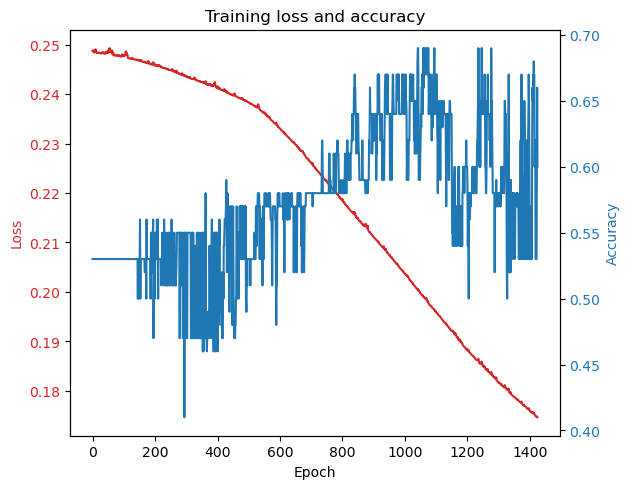

In [39]:
loss_color = "tab:red"
acc_color = "tab:blue"

fig, ax1 = plt.subplots()

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color=loss_color)
ax1.plot(eval_losses, color=loss_color)
ax1.tick_params(axis="y", labelcolor=loss_color)

ax2 = ax1.twinx()
ax2.set_ylabel("Accuracy", color=acc_color)
ax2.plot(eval_acc, color=acc_color)
ax2.tick_params(axis="y", labelcolor=acc_color)

fig.tight_layout()

plt.title("Training loss and accuracy")
plt.show()

In [40]:
print(f"Final training loss: {eval_losses[-1]}")
print(f"Final training accuracy: {eval_acc[-1]}")

Final training loss: 0.1746569573879242
Final training accuracy: 0.6


In [41]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Dtype: {param.dtype}  | {param.data}")

Layer: h1.weight | Dtype: torch.float32  | tensor([[-0.5785, -1.4610,  0.4071,  1.9556,  1.5933,  0.3464]])
Layer: h1.bias | Dtype: torch.float32  | tensor([-0.1611])
Layer: h2.weight | Dtype: torch.float32  | tensor([[-0.3801, -0.7434, -4.4286, -3.9702,  0.5425,  1.1042]])
Layer: h2.bias | Dtype: torch.float32  | tensor([-0.0527])
Layer: h3.weight | Dtype: torch.float32  | tensor([[2.4313, 4.5188]])
Layer: h3.bias | Dtype: torch.float32  | tensor([-2.1963])
